In [1]:
import pandas as pd
import string
import numpy as np
import json
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize

from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.callbacks import CallbackAny2Vec

from numpy.random import seed
seed(1)

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Example code to train Word2Vec models. 
References: 

https://www.analyticsvidhya.com/blog/2021/09/building-a-machine-learning-model-for-title-generation/ 

https://medium.com/analytics-vidhya/predicting-the-ratings-of-reviews-of-a-hotel-using-machine-learning-bd756e6a9b9b

https://medium.com/analytics-vidhya/neural-networks-for-word-embeddings-4b49e0e9c955

https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

Data: 

https://www.kaggle.com/datasets/datasnaek/youtube-new

https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset

Code to read in YouTube Trending Data. This process can be skipped. 

In [2]:
# Load all the datasets 

path = '/Users/dan/YTTnT/archive_1/' # Filepath for first dataset

df1 = pd.read_csv(path + 'USvideos.csv')
df2 = pd.read_csv(path + 'CAvideos.csv')
df3 = pd.read_csv(path + 'GBvideos.csv')

# Load the datasets containing the category names

data1 = json.load(open(path + 'US_category_id.json'))
data2 = json.load(open(path + 'CA_category_id.json'))
data3 = json.load(open(path + 'GB_category_id.json'))

path1 = '/Users/dan/YTTnT/archive/' # Filepath for second dataset

df4 = pd.read_csv(path1 + 'US_youtube_trending_data.csv')
df5 = pd.read_csv(path1 + 'CA_youtube_trending_data.csv')
df6 = pd.read_csv(path1 + 'GB_youtube_trending_data.csv')

data4 = json.load(open(path1 + 'US_category_id.json'))
data5 = json.load(open(path1 + 'CA_category_id.json'))
data6 = json.load(open(path1 + 'GB_category_id.json'))

In [3]:
def category_extractor(data):
    '''Return the dictionary of category_id to category_title for YouTube videos'''
    
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

cat1 = category_extractor(data1)
cat2 = category_extractor(data2)
cat3 = category_extractor(data3)
cat4 = category_extractor(data4)
cat5 = category_extractor(data5)
cat6 = category_extractor(data6)

cat = {**cat1, **cat2, **cat3, **cat4, **cat5, **cat6}

# Map the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))
df4['category_title'] = df4['categoryId'].map(category_extractor(data4))
df5['category_title'] = df5['categoryId'].map(category_extractor(data5))
df6['category_title'] = df6['categoryId'].map(category_extractor(data6))

df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True) # Join the dataframes
df = df.drop_duplicates('video_id') # Drop rows based on duplicate videos

del df1
del df2
del df3
del df4
del df5
del df6

List of Categories on YouTube

In [4]:
category_list_all = pd.DataFrame(set(list(cat.values())), columns=['category']) #Create a DataFrame of the category names
category_list_all

,category
0,Howto & Style
1,Thriller
2,Sports
3,Gaming
4,Documentary
5,Entertainment
6,Science & Technology
7,Anime/Animation
8,Pets & Animals
9,News & Politics


In [5]:
category_list_all.to_csv('Data/category.csv') # Save the category titles to a CSV

In [6]:
# Dictionary of word contractions

apposV2 = {
"are not" : "are not",
"ca" : "can",
"could n't" : "could not",
"did n't" : "did not",
"does n't" : "does not",
"do n't" : "do not",
"had n't" : "had not",
"has n't" : "has not",
"have n't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"is n't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"might n't" : "might not",
"must n't" : "must not",
"sha" : "shall",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"should n't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"were n't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"wo" : "will",
"would n't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"was n't": "was not",
"we'll":"we will",
"did n't": "did not"
}
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [7]:
def cleanTitles(titles):
    '''Clean titles by removing punctuations, numbers, non-English titles, contractions, and stop words, then lemmatizing'''
    
    nlp = spacy.load("en_core_web_sm",disable=['parser','ner'])
    stop = stopwords.words('english')
    all_=[]
    all_stop = []
    for title in tqdm(titles):
        lower_case = title.lower() #lower case the text
        lower_case = lower_case.replace(" n't"," not") #correct n't as not
        lower_case = lower_case.replace("."," . ")
        lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) #remove punctuation
        if lower_case != lower_case.encode('utf8').decode('ascii', 'ignore'):
            all_stop.append('')
            continue
        words = lower_case.split() #split into words
        words = [word for word in words if word.isalpha()] #remove numbers
        split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
        split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
        split = [word for word in split if word not in stop] #remove stop words
        reformed = " ".join(split) #join words back to the text
        doc = nlp(reformed)
        reformed = " ".join([token.lemma_ for token in doc]) #lemmatization
        if reformed == '':
            all_stop.append('')
        else: all_stop.append(str(reformed))
    return all_stop

In [8]:
df['cleaned_title'] = cleanTitles(df['title'])
filename = 'data'
df.to_csv('Data/{0}.csv'.format(filename), columns=['title', 'category_title', 'cleaned_title']) # Save the DataFrame with a colum with cleaned titles added.

100%|███████████████████████████████████████████████████████████████████████████| 92541/92541 [03:10<00:00, 485.30it/s]


Reading in DataFrame from preprocessed file.

In [ ]:
df = pd.read_csv('Data/data.csv', keep_default_na=False) # Read in Data

Code to Train Word2Vec Model. Plots Loss against Training Epoch to see if training is complete. |

Insufficient # of Samples Classics
Insufficient # of Samples Thriller
Insufficient # of Samples Sci-Fi/Fantasy
News & Politics


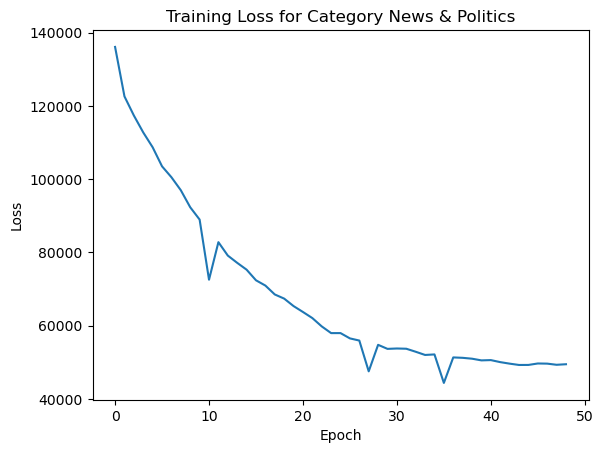

Insufficient # of Samples Horror
Insufficient # of Samples Drama
Autos & Vehicles


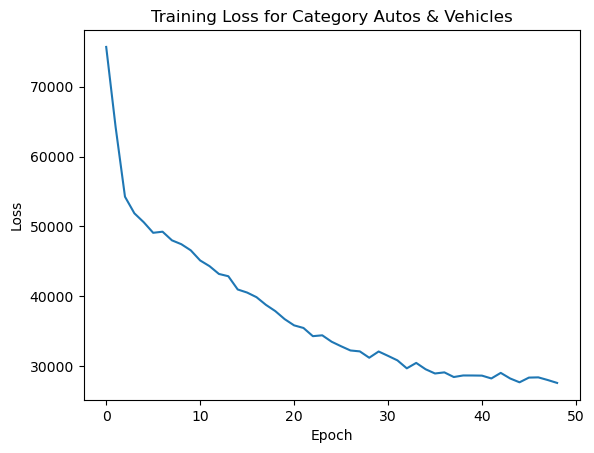

Howto & Style


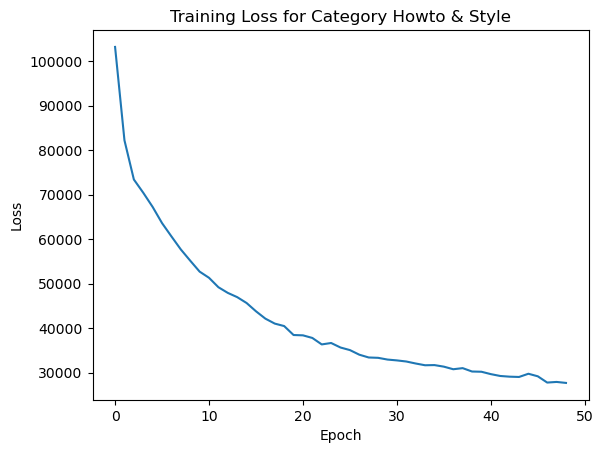

Travel & Events


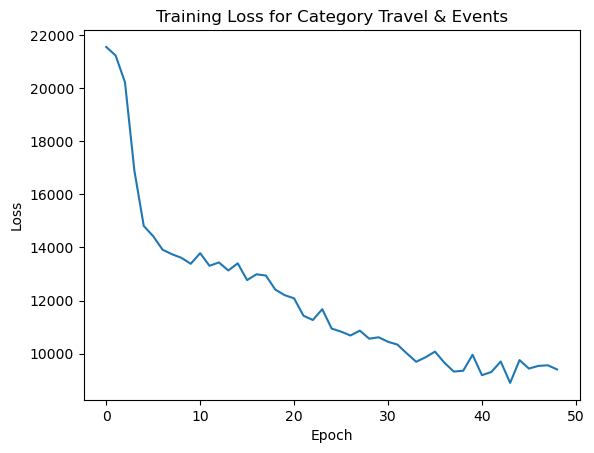

People & Blogs


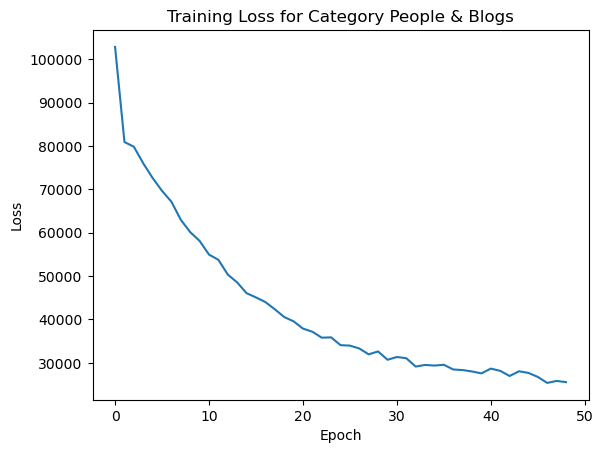

Film & Animation


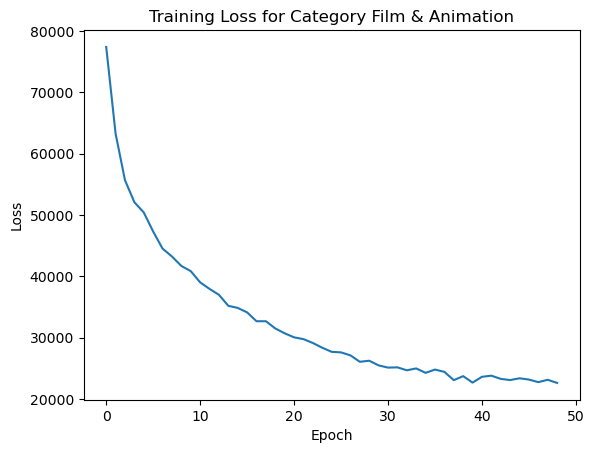

Insufficient # of Samples Shorts
Insufficient # of Samples Movies
Insufficient # of Samples Short Movies
Education


KeyboardInterrupt: 

In [147]:
# Your model params:
CONTEXT_WINDOW = 50 # Bigger than the length of the longest title
NEGATIVES = 5 
MIN_COUNT = 3 
EPOCHS = 50

class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        return

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        self.epoch += 1

for j, category in enumerate(category_list_all): 
    
    # Check if more than 100 titles in category
    i = 0
    for ele in df['cleaned_title'][df['category_title'] == category]:
        if ele != '':
            i = i + 1  
    if i > 100:
        
        print(category)
        # Train a bigram detector.
        bigram_transformer = Phrases(df['cleaned_title'][df['category_title'] == category])

        titles = [word_tokenize(title) for title in df['cleaned_title'][df['category_title'] == category]]
        loss_logger = LossLogger()
        
        # Train a skip-gram model with cleaned titles
        model = Word2Vec(titles,
                  vector_size=int(np.sqrt(i)/4) * 4, # Vector size is determined by the number of titles
                  sg=1,
                  window=CONTEXT_WINDOW,
                  workers=8,
                  negative=NEGATIVES,
                  min_count=MIN_COUNT,
                  callbacks=[loss_logger],
                  compute_loss=True,
                  epochs=EPOCHS)
        
        plt.plot(np.diff(loss_logger.losses))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss for Category {0}'.format(category))
        plt.show()
        model.wv.save('model/{0}.kv'.format(category))
    else:
        print('Insufficient # of Samples ' + category)

In [ ]:
model.wv.key_to_index.keys()